# NLP (Natural Language Processing) with Python
    
**Requirements: You will need to have NLTK installed, along with downloading the corpus for stopwords. To download everything with a conda installation, run the cell below. Or reference the full video lecture**

In [25]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# Uncomment the code below and run:


#!conda install nltk
#import nltk
#nltk.download()
#Download the stopwords package

## Get the Data

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

The file we are using contains a collection of more than 5 thousand SMS phone messages. You can check out the **readme** file for more info.

In [26]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

# You can print the first ten message
#for message_no, message in enumerate(messages[:10]):
#    print(message_no, message)
#    print('\n')

5574


Use Pandas' **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [27]:
import pandas as pd

messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [28]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [29]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [30]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EDB1F60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EE88128>], dtype=object)

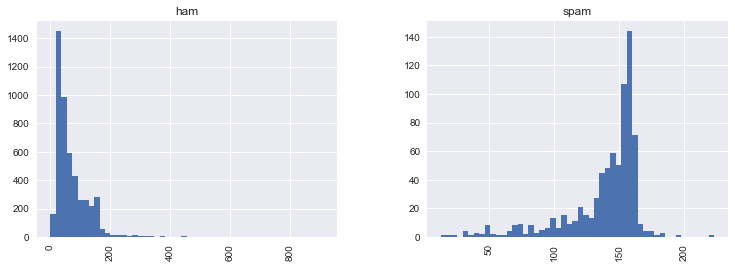

In [32]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Spam messages tend to have more characters.

## Text Pre-processing

Remove punctuation and stopwords.

In [33]:
import string

from nltk.corpus import stopwords
#stopwords.words('english')[0:10] # Show some stop words

In [34]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [35]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html). Explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

## Vectorization

Create a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix): rows are the message and columns are every words of the corpus.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [37]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


(Optional) Convert the bag of word to a **sparse matrix**.

In [ ]:
bow_transformer.toarray()

Example:

In [38]:
# Message
message4 = messages['message'][3]
print(message4)
print("")

# Vector representation
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

# Inverse transform
print(bow_transformer.get_feature_names()[4073])

U dun say so early hor... U c already then say...

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)
UIN


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [39]:
messages_bow = bow_transformer.transform(messages['message'])

In [40]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [41]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


## TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

In [50]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"university"`?

In [51]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

8.5270764989


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [52]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

With messages represented as vectors, the Naive Bayes classifier algorithm is [a good choice](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf).

In [53]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [54]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


## Part 6: Model Evaluation

## Train Test Split

In [56]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow.

In [57]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [58]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000000000EB370D0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [59]:
predictions = pipeline.predict(msg_test)

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification).

In [60]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98       999
       spam       0.75      1.00      0.86       116

avg / total       0.97      0.97      0.97      1115



# Ngrams

In [15]:
X = ["Some say the world will end in fire,", "Some say in ice."]
from sklearn.feature_extraction.text import CountVectorizer

# Get unigram and bigrams
gram_vectorizer = CountVectorizer(ngram_range=(1, 2))
gram_vectorizer.fit(X)

# Find the most frequent ngram
counts = gram_vectorizer.transform(X)
most_common = np.argmax(counts.sum(axis=0))
gram_vectorizer.get_feature_names()[most_common]

'in'

In [11]:
# Note you can look at most frequent characters with
char_vectorizer = CountVectorizer(ngram_range=(2, 2), analyzer="char")
char_vectorizer.fit(X)
char_vectorizer.get_feature_names()[:6]

[' e', ' f', ' i', ' s', ' t', ' w']

## More Resources

Check out the links below for more info on Natural Language Processing:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)